In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import scipy.stats as stats

from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [82]:
# IMPORT: Tableau Superstore dataset

df = pd.read_csv("../data/superstore_sample.csv")

In [83]:
# CHANGE: to natural format: non-numeric types

# Type Change: 2 columns -> str
df['Customer ID'] = df['Customer ID'].astype("string")
df['Product ID'] = df['Product ID'].astype("string")

# Type Change: 5 columns -> category 
df['Ship Mode'] = df['Ship Mode'].astype("category")
df['Segment'] = df['Segment'].astype("category")
df['Region'] = df['Region'].astype("category")
df['Category'] = df['Category'].astype("category")
df['Sub-Category'] = df['Sub-Category'].astype("category")

# Type Change: 2 columns -> datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

In [84]:
# CHANGE: datetime to int

df['Order Date'] = df['Order Date'].astype(int) / 10**14
df['Ship Date'] = df['Ship Date'].astype(int) / 10**14

In [85]:
# DEFINE: column types

id_columns = [
    "Customer ID", "Product ID",
]

# Potential target variables
numeric_columns = [
    "Sales", "Quantity", "Discount", "Profit"
]

category_columns = [
    "Ship Mode", #4
    "Segment", #3
    "Region", #4
    "Category", #3
    "Sub-Category" #17
]

void_columns = [
   "Row ID", "Order ID", "Country"
]

# Customer Name <-> Customer ID
# Product Name <-> Product ID
# [City, State, Postal Code] <-> Region
redundant_columns = [
    "Customer Name", "Product Name", 
    "City", "State", "Postal Code"
]

In [86]:
# ASSIGN: numeric id instead of string id
# Customer Id -> C_id
# Product Id -> 

for i in id_columns:
    df[i[0]+'_id'] = df.groupby(i).ngroup()

In [87]:
# DROP: 10 Columns = id + void + redundant
dropping_columns = id_columns + void_columns + redundant_columns

df_f = df.drop(columns=dropping_columns)

In [88]:
# PROFILE: exploratory analysis & save to HTML - uncomment when needed

# import ydata_profiling as yp

# report_super_f = df_f.profile_report()
# report_super_f.to_file(output_file="0409_super_f_report.html")

In [89]:
# ENCODE: One-Hot Encode 5 categorical variables
# "Ship Mode"#4 "Segment"#3 "Region"#4 "Category"#3 "Sub-Category"#17

for i in category_columns:
    ohe = OneHotEncoder()
    ohe_df = pd.DataFrame(
        ohe.fit_transform(df_f[[i]]).toarray())
    # add suffix to column names in ohe_df
    ohe_df.columns = ohe_df.columns.astype(str)
    ohe_df = ohe_df.add_suffix(i)
    # define new dataframe to distinguish before-and-after encoding
    df_f = df_f.join(ohe_df)

In [90]:
# DROP & Standardize: categorical variables

# will have to check how much data deviates from Gaussian
# for now, assume it fares ok 
# = leave it as window for improvement
scaler = StandardScaler()

# Save standardized dataframe in a new variable,
# for preliminary model training and testing
scaled_df_f = scaler.fit_transform(
    df_f.drop(category_columns, axis=1))

## QQPlots for non-categorical columns

In [91]:
# DEFINE: qdf dataframe for qqplot
qdf = df_f[numeric_columns]
qdf.columns

Index(['Sales', 'Quantity', 'Discount', 'Profit'], dtype='object')

/var/folders/cq/4vwhjr3125jb36fr9d1d8pdr0000gn/T/ipykernel_29424/510744638.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, n+1)


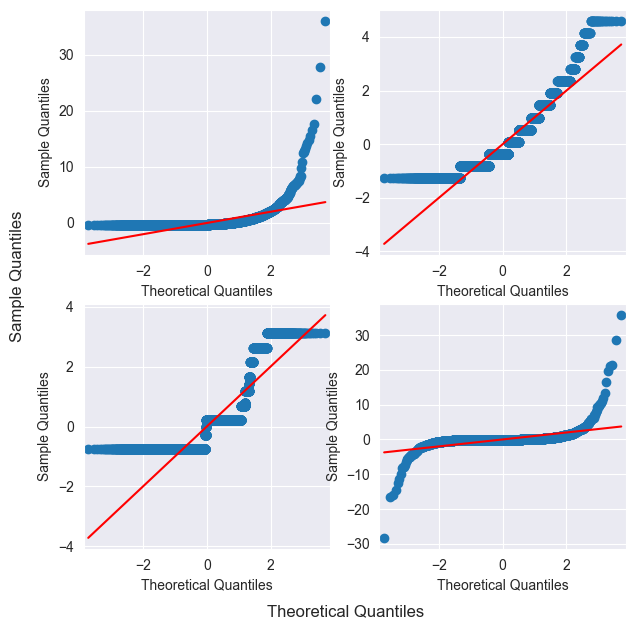

In [92]:
# DRAW: 4 qqplots = Sales, Quantity, Discount, Profit

fig, ax = plt.subplots(figsize=(7,7), sharex=True)

for n, i in enumerate(qdf.columns):
    plt.subplot(2, 2, n+1)
    # line fit to normal standardization
    plot = sm.qqplot(qdf[i], ax=plt.gca(),
                     fit=True, line="s")
fig.supxlabel('Theoretical Quantiles')
fig.supylabel('Sample Quantiles')
plt.show()

## Testing Normality for numeric_columns

In [93]:
# DEFINE: reference to numeric columns in dataset
ndf = df_f[numeric_columns]
ndf.columns

Index(['Sales', 'Quantity', 'Discount', 'Profit'], dtype='object')

In [94]:
# MIN & MAX: Sales, Quantity, Discount, Profit
for i in numeric_columns:
    print("{0}>> min: {1}, max: {2}\n".format(
        i, ndf[i].min(), ndf[i].max()
    ))

Sales>> min: 0.444, max: 22638.48

Quantity>> min: 1, max: 14

Discount>> min: 0.0, max: 0.8

Profit>> min: -6599.978, max: 8399.976



In [137]:
# DEFINE: products +profit -profit 0profit

good_df = df_f[df_f['Profit']>0].groupby('P_id').agg({'Profit': ['count', 'sum']})
zero_df = df_f[df_f['Profit']==0].groupby('P_id').agg({'Profit': ['count', 'sum']})
bad_df = df_f[df_f['Profit']<0].groupby('P_id').agg({'Profit': ['count', 'sum']})

good_df.columns = ['order_count', 'profit_sum']
zero_df.columns = ['order_count', 'profit_sum']
bad_df.columns = ['order_count', 'profit_sum']

for i in [good_df, zero_df, bad_df]:
    i = i.reset_index()
    i = i.set_index('P_id')

print(good_df.shape, bad_df.shape, zero_df.shape)

(1803, 2) (762, 2) (28, 2)


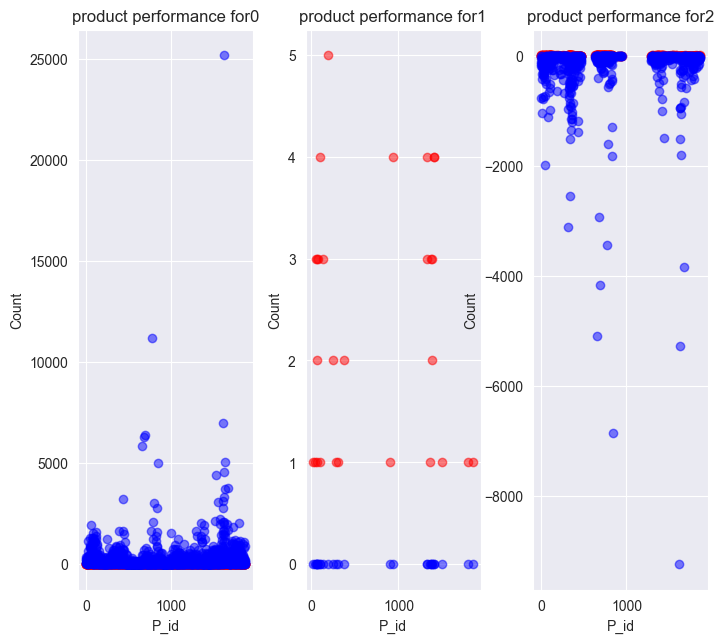

In [142]:
# PLOT: count of orders & profit sum on each product
df_list = [good_df, zero_df, bad_df]
fig, axes = plt.subplots(1, 3, figsize=(7,7))
for i in range(3):
    axes[i].scatter(x=df_list[i].index, y=df_list[i]['order_count'], color='red', alpha=0.5)
    axes[i].scatter(x=df_list[i].index, y=df_list[i]['profit_sum'], color='blue', alpha=0.5)
    axes[i].set_xlabel('P_id')
    axes[i].set_ylabel('Count')
    axes[i].set_title('product performance for{}'.format(i))
ax.set_xlabel('P_id')
ax.set_ylabel('Count / Sum')
ax.set_title('Scatter plot of profits count and sum for each P_id')
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.3)

plt.show()

/var/folders/cq/4vwhjr3125jb36fr9d1d8pdr0000gn/T/ipykernel_29424/3302210842.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, kde=False, fit=stats.johnsonsu)
/var/folders/cq/4vwhjr3125jb36fr9d1d8pdr0000gn/T/ipykernel_29424/3302210842.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, kd

<AxesSubplot: title={'center': 'Log Normal'}, xlabel='Sales'>

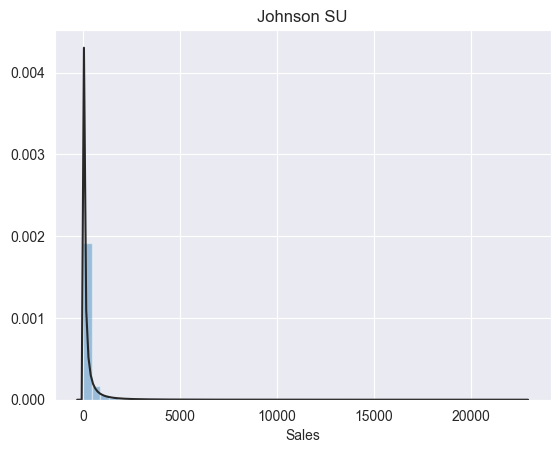

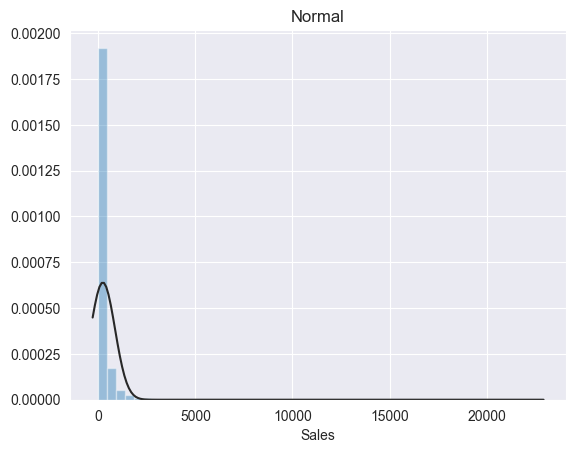

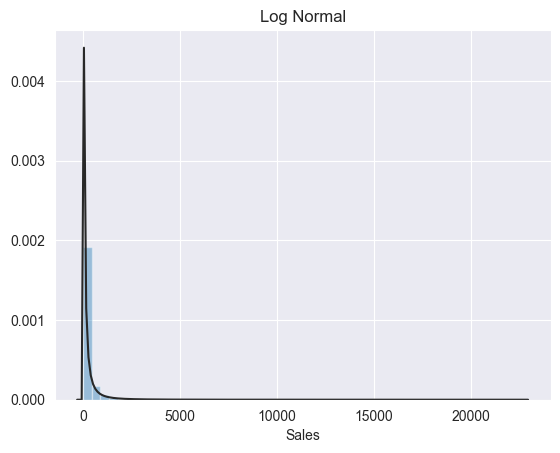

In [96]:


y = df_f['Sales']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

      Order Date  Ship Date       Ship Mode    Segment Region  \
0      14785.632  14788.224    Second Class   Consumer  South   
1      14785.632  14788.224    Second Class   Consumer  South   
2      14656.896  14660.352    Second Class  Corporate   West   
3      14445.216  14451.264  Standard Class   Consumer  South   
4      14445.216  14451.264  Standard Class   Consumer  South   
...          ...        ...             ...        ...    ...   
9989   13902.624  13904.352    Second Class   Consumer  South   
9990   14880.672  14884.992  Standard Class   Consumer   West   
9991   14880.672  14884.992  Standard Class   Consumer   West   
9992   14880.672  14884.992  Standard Class   Consumer   West   
9993   14938.560  14942.880    Second Class   Consumer   West   

             Category Sub-Category     Sales  Quantity  Discount  ...  \
0           Furniture    Bookcases  261.9600         2      0.00  ...   
1           Furniture       Chairs  731.9400         3      0.00  ...   


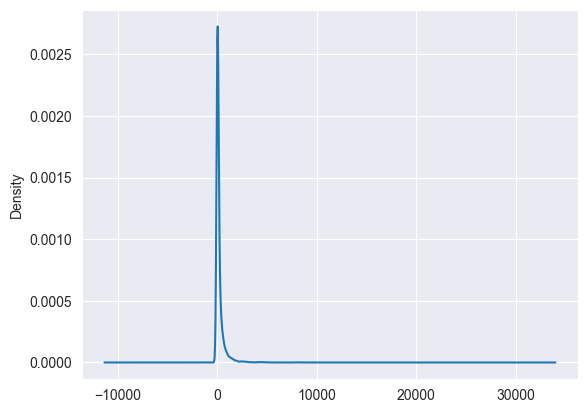

In [97]:
df_f['Sales'].plot(kind='kde')
print(df_f)

In [98]:
q1 = df["Sales"].quantile(0.01)
q25 = df["Sales"].quantile(0.25)
q50 = df["Sales"].quantile(0.50)
q75 = df["Sales"].quantile(0.75)
q99 = df["Sales"].quantile(0.99)
print(q1)
print(q25)
print(q75)
print(q99)

2.286
17.28
209.94
2481.694599999993


In [99]:
compact_df = df_f[(df_f["Sales"] < q99) & (df_f["Sales"] > q1)]
verycompact_df = df_f[(df_f["Sales"] < q75) & (df_f["Sales"] > q25)]

In [100]:
print(df_f.shape)
print(compact_df.shape[0])
print(verycompact_df.shape[0])

(9994, 44)
9793
4993


In [101]:
df_f.shape[0] - compact_df.shape[0]

201

In [102]:
# df_f[df_f["Sales"]>2000].groupby("Product ID_id")["Sales"].count()
df_f[df_f["Sales"]>100]["Sales"].count()

3765

In [103]:
# from scipy.stats import mstats
# quantiles = mstats.mquantiles(df_f["Sales"], axis=0)
# labels = ['1%', '25%', '50%', '75%', '99%']
# for i, q in enumerate(quantiles):
#     plt.plot(q, label=labels[i])
# plt.legend()

In [104]:
# SHAPIRO TEST: none of the numeric columns has normal distribution
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
for i in [df_f, compact_df, verycompact_df]:
    normal = pd.DataFrame(i[numeric_columns])
    normal = normal.apply(test_normality)
    print(not normal.any())

False
False
False


/Users/silmari/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/silmari/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


# Testing For Methods ->>>>>

In [105]:
# perform PCA
pca = PCA(n_components=4)
pca_df = pca.fit_transform(scaled_df_f)

# print the results
print(("Explained Variance: %s") % (pca.explained_variance_ratio_))

Explained Variance: [0.08287118 0.0753866  0.0518108  0.04530148]


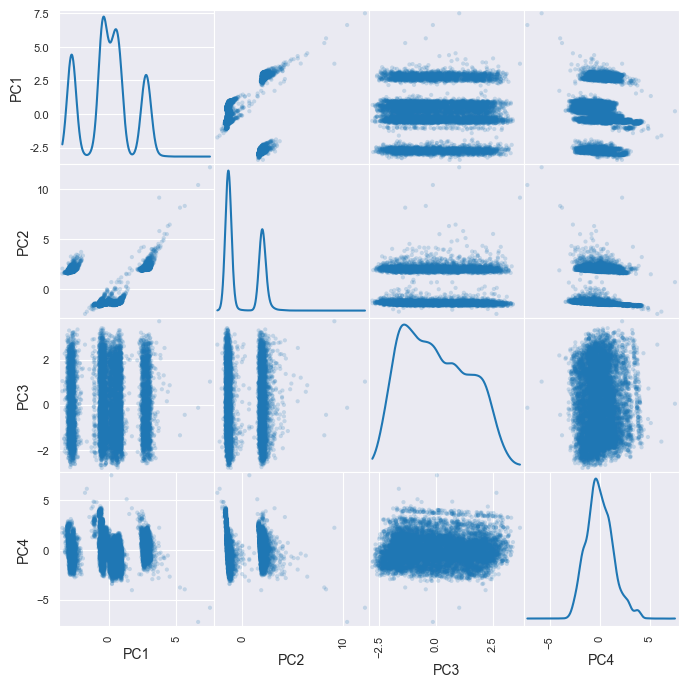

In [106]:
from pandas.plotting import scatter_matrix

pca_df_pd = pd.DataFrame(pca_df, columns=['PC1', 'PC2', 'PC3', 'PC4'])
scatter_matrix(pca_df_pd, alpha=0.2, figsize=(8, 8), diagonal='kde')
plt.show()

## From PCA, dataset is unlikely to encompass a linear structure -->>>>

In [107]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(scaled_df_f, test_size=0.33)

from sklearn.datasets import load_digits
from sklearn.decomposition import KernelPCA
scaled_df_f, _ = load_digits(return_X_y = True)
kpca = KernelPCA(n_components=None, kernel='sigmoid', fit_inverse_transform=True, alpha=0.1)
# df_transformed = kpca.fit_transform(scaled_df_f)

test_pca = pca.fit(train).transform(test)
# test_kpca = kpca.fit(train).transform(test)
# print(df_transformed.shape)

In [108]:
# create a KernelPCA object
# kpca = KernelPCA(n_components=2, kernel='rbf')

# # fit the model on the training data
# train_kpca = kpca.fit_transform(train)

# # transform the test data
# test_kpca = kpca.transform(test)


In [109]:
# check if all values are between -1 and 1
is_scaled = np.all((scaled_df_f >= -1) & (scaled_df_f <= 1), axis=0)

# get the columns with values that are not scaled between -1 and 1
not_scaled_columns = np.where(~is_scaled)[0]

print(f"Columns with values that are not scaled between -1 and 1: {not_scaled_columns}")

Columns with values that are not scaled between -1 and 1: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25
 26 27 28 29 30 33 34 35 36 37 38 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 55 57 58 59 60 61 62 63]


In [110]:
# kernel_matrix = kpca.get_params()['kernel'](test_kpca)

# # compute eigenvalues of the kernel matrix
# eigenvalues, _ = np.linalg.eig(kernel_matrix)

# # check if all eigenvalues are non-negative
# if np.all(eigenvalues >= 0):
#     print("Kernel matrix is PSD.")
# else:
#     print("Kernel matrix is not PSD.")

NameError: name 'test_kpca' is not defined

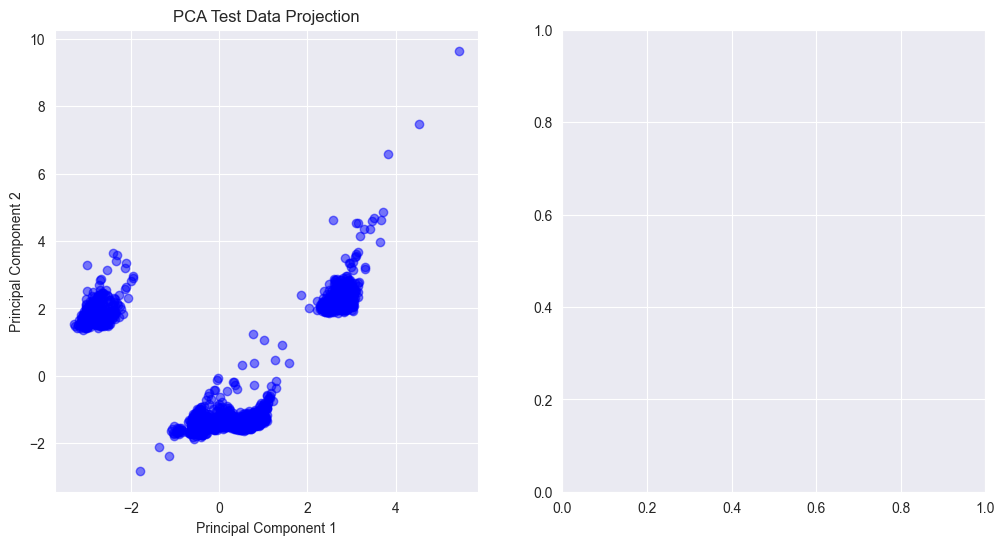

In [111]:
# Plot the transformed test data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(test_pca[:, 0], test_pca[:, 1], c='blue', marker='o', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Test Data Projection')

plt.subplot(1, 2, 2)
plt.scatter(test_kpca[:, 0], test_kpca[:, 1], c='red', marker='o', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KPCA Test Data Projection')

plt.show()

## kernel PCA is not working as well ->>>>>

In [ ]:
train.shape

(6695, 39)

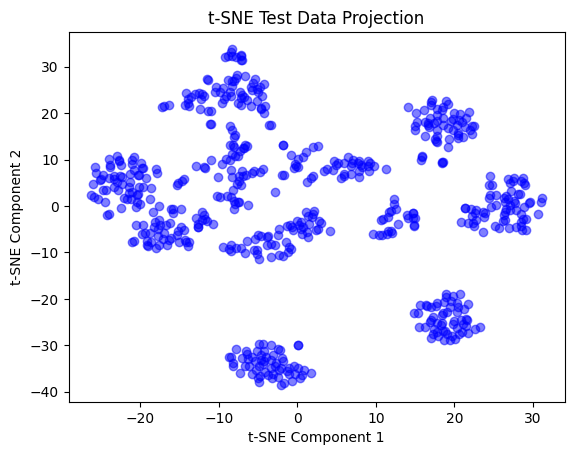

In [ ]:
# t-Distributed Stochastic Neighbor Embedding

from sklearn.manifold import TSNE
train, test = train_test_split(scaled_df_f, test_size=0.33)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=2023, perplexity=30)
train_tsne = tsne.fit_transform(train)
test_tsne = tsne.fit_transform(test)

# Plot the transformed test data
plt.scatter(test_tsne[:, 0], test_tsne[:, 1], c='blue', marker='o', alpha=0.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Test Data Projection')
plt.show()

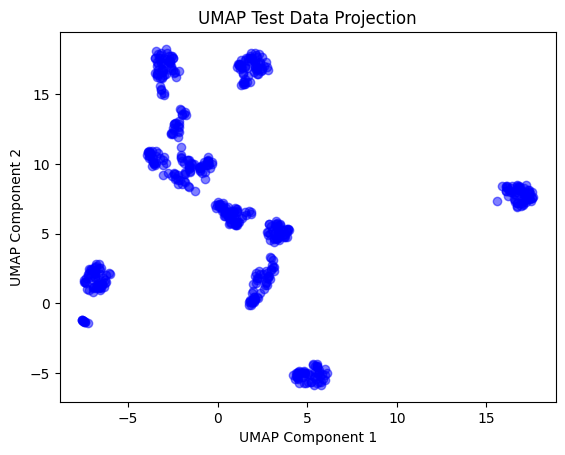

In [ ]:
# Uniform Manifold Approximation and Projection

from umap import UMAP
train, test = train_test_split(scaled_df_f, test_size=0.33)

# Apply UMAP
umap = UMAP(n_components=2, random_state=42)
train_umap = umap.fit_transform(train)
test_umap = umap.transform(test)

# Plot the transformed test data
plt.scatter(test_umap[:, 0], test_umap[:, 1], c='blue', marker='o', alpha=0.5)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Test Data Projection')
plt.show()

## t-sne, umap both could be pluasible to use in dimensionality reduction -->>>>